In [1]:
import yaml
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, scoped_session
import pandas as pd
import mplfinance as mpf

from core import config
from chan import interval_period, get_data, add_bollinger_bands, add_macd, merge_candle, identify_fractal, filter_fractals, filter_fractals, find_centers, add_plots, add_lines, add_rectangles

In [2]:
symbol = 'HOTUSDT'
interval = '2h'
amount = 1000
df = get_data(symbol, interval_period[interval], amount)
df = df[:-1]

# 先将布林带数值计算出来
df = add_bollinger_bands(df)
# 再将MACD数值计算出来
df = add_macd(df)
# 处理K线的包含关系
df_merged = merge_candle(df)
# 判断是否有分型
df_fractal = identify_fractal(df_merged)
# 过滤掉无效的分型
df_filtered = filter_fractals(df_fractal)
# 找出中枢
df_centered = find_centers(df_filtered)

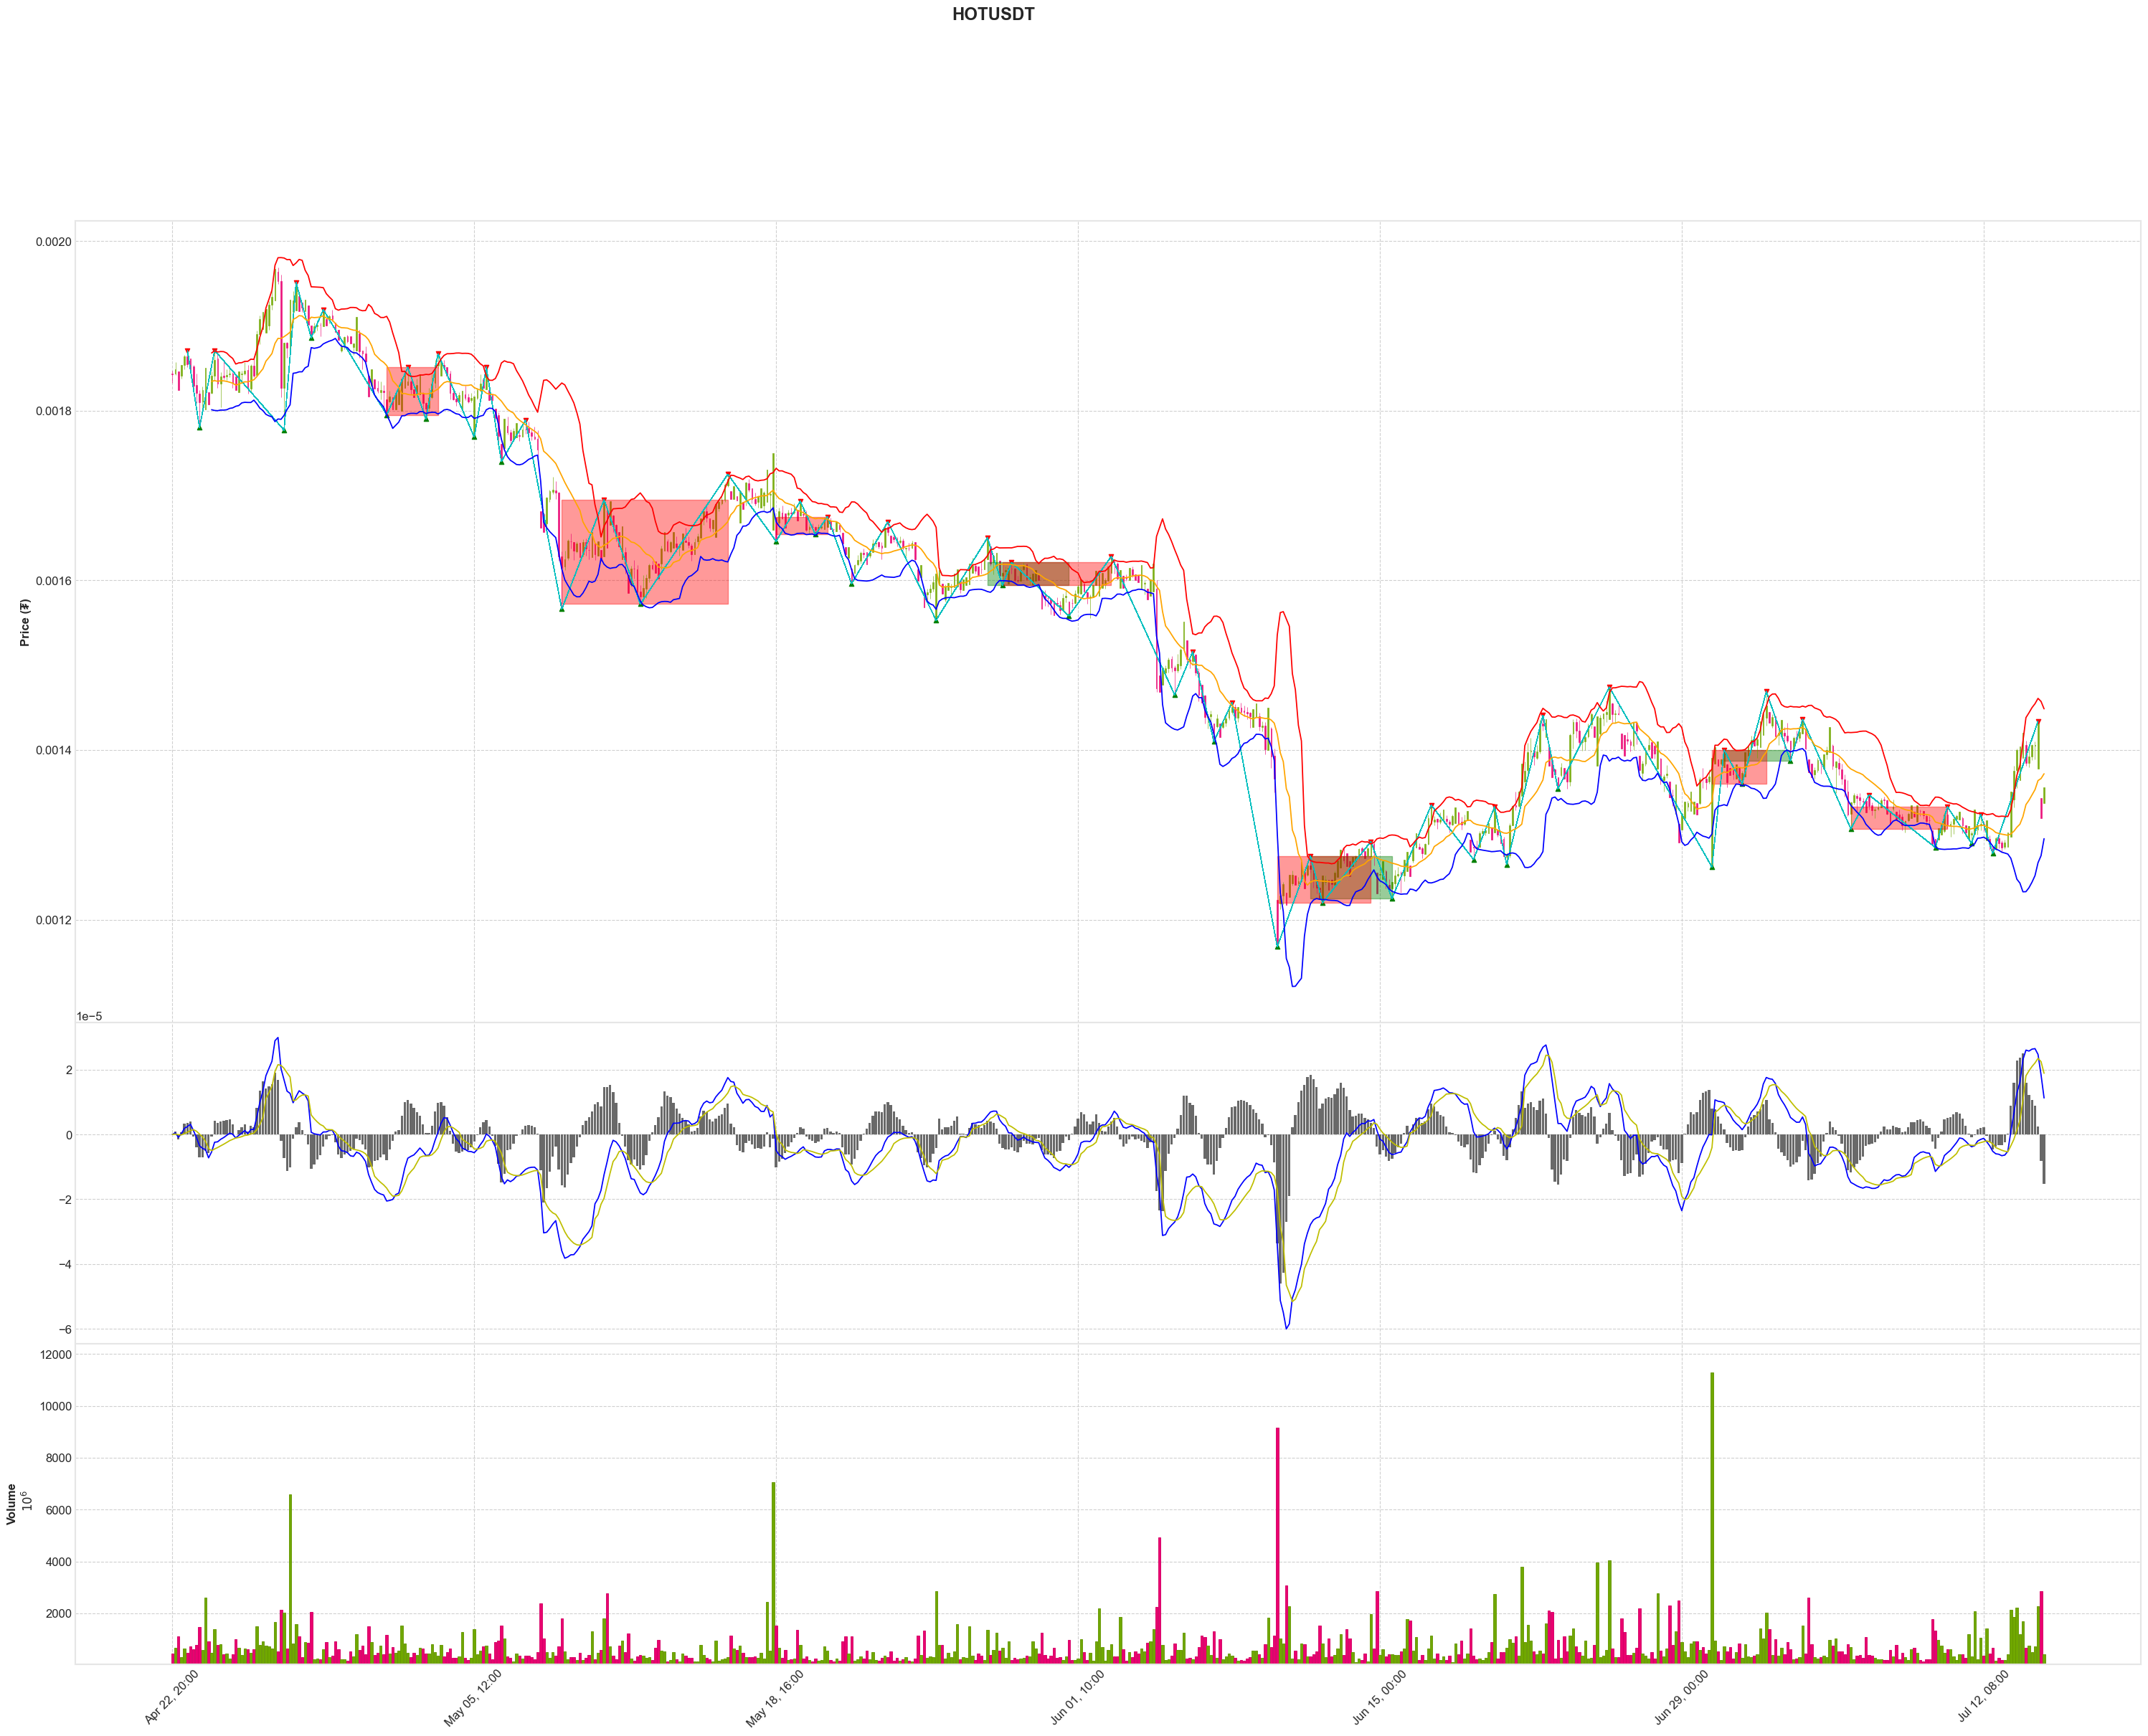

In [3]:
addplot_all = add_plots(df_centered)
all_lines = add_lines(df_centered)
rectangles = add_rectangles(df_centered)

# 绘制图表
mpf.plot(df_centered, figscale=5, type='candle', style='binance', title=symbol, ylabel='Price (₮)', volume=True, ylabel_lower='Volume', volume_panel=2, addplot=addplot_all, alines=all_lines, fill_between=rectangles, warn_too_much_data=1000)